In [1]:
import numpyro

numpyro.enable_x64()
numpyro.set_platform('gpu') # set it to cpu and increase the number of devices if required

# MOCK LOSER Q DYNAMICS

2024-05-06 18:36:46.819577: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


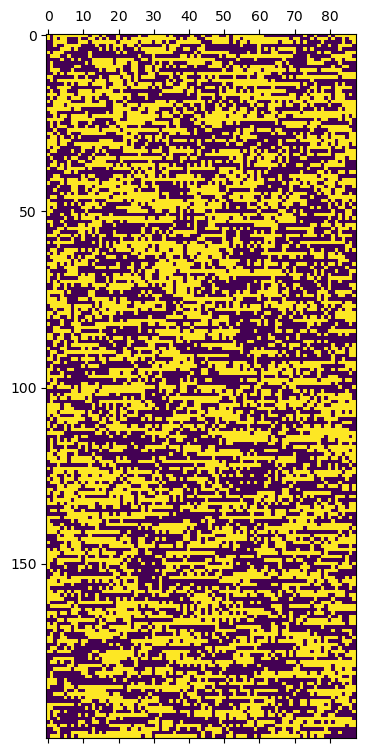

In [2]:
import numpy as np 
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax.random import PRNGKey
from helper import StateTools

markov_util_ref = StateTools(4)

probs = jnp.empty((2**4))
probs_keys = {0. : 0.25, 0.25:1/3, 0.5:0.5, 0.75:2/3, 1.:0.75}

for i, state in enumerate(markov_util_ref.get_states()):
    probs = probs.at[i].set(probs_keys[sum(state)/4])
    
mock_history_encoded = markov_util_ref.build_process(85, probs=probs).sample(200, seed=PRNGKey(42))
mock_history = np.apply_along_axis(markov_util_ref.categorical_serie_to_binary, 1, mock_history_encoded)
plt.matshow(mock_history);

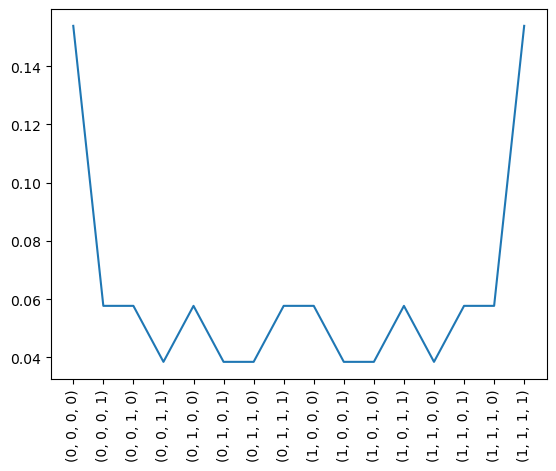

In [3]:
stat_distribution = markov_util_ref.stationary_distribution(probs)
states = markov_util_ref.get_states()
plt.plot([str(x) for x in states], stat_distribution)
plt.xticks(rotation=90);

In [34]:
import arviz as az 
import tensorflow_probability.substrates.jax.distributions as tfd
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from jax.random import PRNGKey

dict_of_id = {}

for i in range(4, -1, -1):
    
    markov_util = StateTools(i)

    def model():
        
        if i != 0: 
            proba = numpyro.sample('proba', dist.Uniform(low=jnp.zeros(2**markov_util.n), high=jnp.ones(2**markov_util.n)))
        else:
            proba = numpyro.sample('proba', dist.Uniform(low=0, high=1))*jnp.ones(2**markov_util.n)
            
        transition_matrix = markov_util.build_transition_matrix(proba)
        
        def transition_fn(_, x):
            return tfd.Categorical(probs=transition_matrix[x])
        
        encoded_history = np.apply_along_axis(markov_util.binary_serie_to_categorical, 1, mock_history)
        
        likelihood_dist = tfd.MarkovChain(
                initial_state_prior=tfd.Categorical(probs=markov_util.uniform_prior),
                transition_fn=transition_fn,
                num_steps=encoded_history.shape[1]
        )
        
        numpyro.sample('likelihood', likelihood_dist, obs=encoded_history)

    kernel = NUTS(model)
    num_samples = 2000
    mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples, num_chains=4, chain_method='vectorized')
    mcmc.run(
        PRNGKey(0)
    )
    mcmc.print_summary()
    
    dict_of_id[str(i)] = az.from_numpyro(mcmc)

sample: 100%|██████████| 3000/3000 [00:43<00:00, 69.70it/s]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  proba[0]      0.26      0.01      0.26      0.24      0.27  19237.44      1.00
  proba[1]      0.32      0.01      0.32      0.30      0.35  20408.05      1.00
  proba[2]      0.32      0.02      0.32      0.29      0.34  21285.35      1.00
  proba[3]      0.49      0.02      0.49      0.46      0.52  19726.86      1.00
  proba[4]      0.33      0.01      0.33      0.31      0.36  21986.24      1.00
  proba[5]      0.51      0.02      0.51      0.48      0.55  19044.38      1.00
  proba[6]      0.50      0.02      0.50      0.47      0.54  21387.55      1.00
  proba[7]      0.68      0.01      0.68      0.65      0.70  19906.23      1.00
  proba[8]      0.30      0.01      0.30      0.27      0.32  21966.43      1.00
  proba[9]      0.50      0.02      0.50      0.47      0.53  23740.87      1.00
 proba[10]      0.49      0.02      0.49      0.46      0.53  21120.50      1.00
 proba[11]      0.68      0

sample: 100%|██████████| 3000/3000 [00:25<00:00, 117.56it/s]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  proba[0]      0.27      0.01      0.27      0.26      0.28  13722.15      1.00
  proba[1]      0.39      0.01      0.39      0.37      0.41  13593.27      1.00
  proba[2]      0.39      0.01      0.39      0.37      0.40  14152.79      1.00
  proba[3]      0.60      0.01      0.60      0.58      0.62  12668.82      1.00
  proba[4]      0.39      0.01      0.39      0.37      0.41  13634.96      1.00
  proba[5]      0.62      0.01      0.62      0.60      0.64  14502.98      1.00
  proba[6]      0.60      0.01      0.60      0.58      0.62  14543.07      1.00
  proba[7]      0.73      0.01      0.73      0.72      0.75  13948.48      1.00

Number of divergences: 0


sample: 100%|██████████| 3000/3000 [00:17<00:00, 174.40it/s]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  proba[0]      0.31      0.01      0.31      0.30      0.32   9377.08      1.00
  proba[1]      0.51      0.01      0.51      0.49      0.52   9489.58      1.00
  proba[2]      0.50      0.01      0.50      0.48      0.51   7622.03      1.00
  proba[3]      0.69      0.01      0.69      0.68      0.70   8759.24      1.00

Number of divergences: 0


sample: 100%|██████████| 3000/3000 [00:15<00:00, 191.92it/s]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  proba[0]      0.38      0.01      0.38      0.37      0.39   6848.01      1.00
  proba[1]      0.62      0.01      0.62      0.61      0.63   7297.52      1.00

Number of divergences: 0


sample: 100%|██████████| 3000/3000 [00:09<00:00, 310.44it/s]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     proba      0.50      0.00      0.50      0.49      0.51   2747.49      1.00

Number of divergences: 0


In [35]:
az.compare(dict_of_id)

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
4,0,-10994.278085,14.954080,0.000000,9.992067e-01,55.572979,0.000000,False,log
3,1,-11154.893777,8.068960,160.615693,7.932990e-04,52.881732,18.480330,False,log
2,2,-11396.933243,4.802446,402.655159,1.079545e-10,47.201769,27.657451,False,log
1,3,-11697.073890,3.527438,702.795806,0.000000e+00,36.556748,35.533896,False,log
0,4,-12201.689296,3.588990,1207.411212,0.000000e+00,0.254850,55.622123,False,log


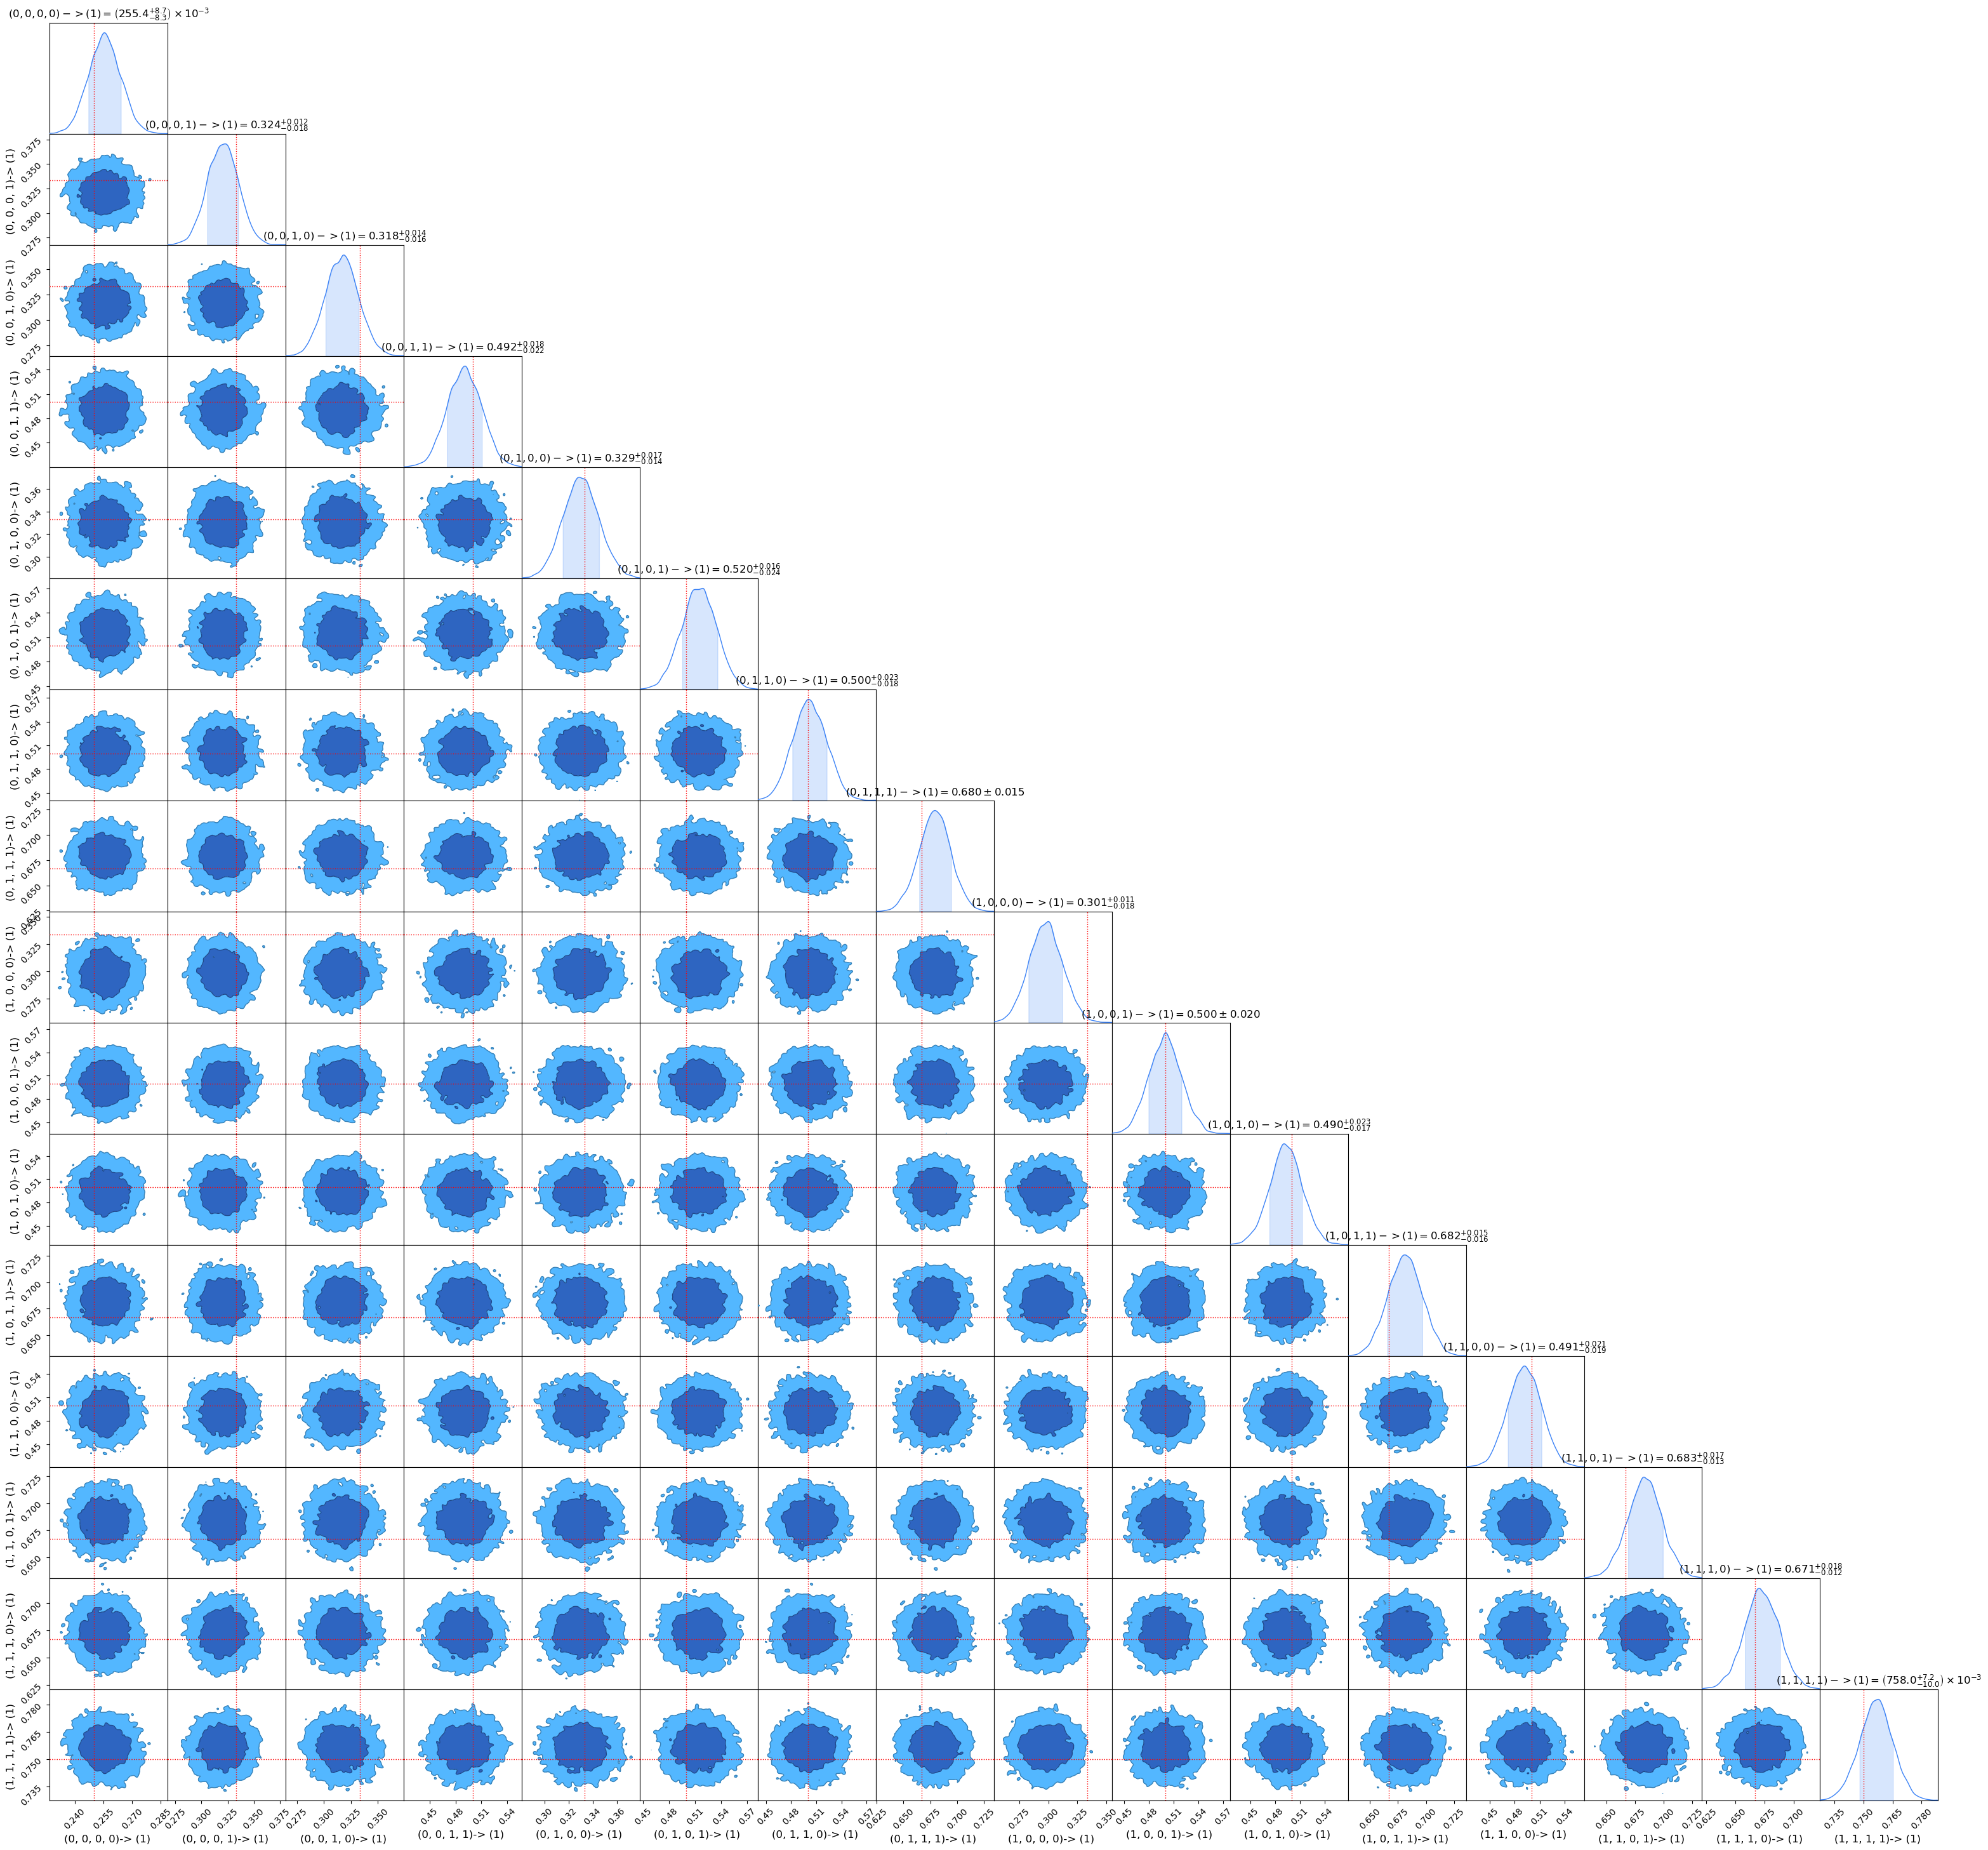

"\ncc.plotter.plot_summary()\nplt.tight_layout()\nplt.savefig('test_summaries.png', bbox_inches='tight')\n"

In [23]:
import pandas as pd 
from chainconsumer import ChainConsumer, Chain, Truth

best_id = dict_of_id['4']
samples = np.asarray(az.extract(best_id).proba)

dict_of_samples = {str(state) + '-> (1)':samples[i] for i, state in enumerate(markov_util_ref.get_states())}

cc = ChainConsumer()
cc.add_chain(Chain(samples=pd.DataFrame.from_dict(dict_of_samples), name='ref'))
cc.add_truth(Truth(location={str(state) + '-> (1)':probs_keys[sum(state)/4] for i, state in enumerate(markov_util_ref.get_states())}, line_style=":", color="red"))
cc.plotter.plot()
plt.show()
#plt.savefig('test_summaries_corner.png', bbox_inches='tight')

"""
cc.plotter.plot_summary()
plt.tight_layout()
plt.savefig('test_summaries.png', bbox_inches='tight')
"""

In [45]:
from jax.tree_util import tree_flatten, tree_map, tree_reduce
from helper import get_history_dict, get_tier_sorted

history = get_history_dict()

#smallest_history_size = tree_reduce(min, tree_map(lambda x: x.shape[0], history))
#flat_tree, _ = tree_flatten(tree_map(lambda x: x[-smallest_history_size:], history))
#observed_history = jnp.asarray(flat_tree)

In [47]:
import arviz as az 
import jax
from numpyro.infer import MCMC, NUTS
from jax.random import PRNGKey

results_per_tier = {}

for tier in get_tier_sorted():

    dict_of_id = {}
    local_history = history[tier]
    smallest_history_size = tree_reduce(min, tree_map(lambda x: x.shape[0], local_history))
    flat_tree, _ = tree_flatten(tree_map(lambda x: x[-smallest_history_size:], local_history))
    observed_history = jnp.asarray(flat_tree)
    
    for i in range(4, -1, -1):
        
        markov_util = StateTools(i)
        encoded_history = np.apply_along_axis(markov_util.binary_serie_to_categorical, 1, observed_history)
        encoded_history = jax.device_put(encoded_history)
    
        def model():
            
            if i != 0: 
                proba = numpyro.sample('proba', dist.Uniform(low=jnp.zeros(2**markov_util.n), high=jnp.ones(2**markov_util.n)))
            else:
                proba = numpyro.sample('proba', dist.Uniform(low=0, high=1))*jnp.ones(2**markov_util.n)
                    
            transition_matrix = markov_util.build_transition_matrix(proba)
            
            def transition_fn(_, x):
                return tfd.Categorical(probs=transition_matrix[x])
            
            encoded_history = np.apply_along_axis(markov_util.binary_serie_to_categorical, 1, observed_history)
            
            likelihood_dist = tfd.MarkovChain(
                    initial_state_prior=tfd.Categorical(probs=markov_util.uniform_prior),
                    transition_fn=transition_fn,
                    num_steps=encoded_history.shape[1]
            )
            
            numpyro.sample('likelihood', likelihood_dist, obs=encoded_history)
    
        kernel = NUTS(model)
        num_samples = 2000
        mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples, num_chains=4, chain_method='vectorized')
        mcmc.run(
            PRNGKey(0)
        )
        #mcmc.print_summary()
        
        dict_of_id[str(i)] = az.from_numpyro(mcmc)

    print(f"____________{tier}____________")
    print(az.compare(dict_of_id))

    results_per_tier[tier] = dict_of_id

sample: 100%|██████████| 3000/3000 [00:08<00:00, 343.79it/s]


____________IRON_IV____________
   rank     elpd_loo      p_loo  elpd_diff        weight         se       dse  \
0     0 -5826.125893   0.810449   0.000000  5.812812e-01  10.087412  0.000000   
1     1 -5827.049933   1.712543   0.924039  4.922546e-14  10.071128  0.151765   
2     2 -5827.877444   3.595288   1.751550  6.026535e-14  10.052786  1.433392   
4     3 -5828.074895  15.797954   1.949002  4.187188e-01  11.275869  5.082674   
3     4 -5833.669529   7.718066   7.543636  0.000000e+00  10.066395  2.394721   

   warning scale  
0    False   log  
1    False   log  
2    False   log  
4    False   log  
3    False   log  


sample: 100%|██████████| 3000/3000 [00:11<00:00, 251.68it/s]


____________IRON_III____________
   rank     elpd_loo      p_loo  elpd_diff        weight        se       dse  \
0     0 -5949.091635   0.383636   0.000000  1.000000e+00  3.090070  0.000000   
1     1 -5950.108255   1.444369   1.016619  0.000000e+00  3.103904  0.074740   
2     2 -5950.841576   3.196491   1.749941  0.000000e+00  3.366605  1.308095   
3     3 -5952.883932   7.214017   3.792297  0.000000e+00  3.923777  2.606872   
4     4 -5960.085227  16.030000  10.993592  8.815171e-14  4.627163  3.191182   

   warning scale  
0    False   log  
1    False   log  
2    False   log  
3    False   log  
4    False   log  


sample: 100%|██████████| 3000/3000 [00:08<00:00, 345.45it/s]


____________IRON_II____________
   rank     elpd_loo      p_loo  elpd_diff    weight        se       dse  \
0     0 -6096.564731   0.371332   0.000000  0.532468  1.659652  0.000000   
1     1 -6096.607791   1.203590   0.043059  0.467532  1.897829  1.192181   
2     2 -6097.592403   2.927670   1.027672  0.000000  2.248721  1.735982   
3     3 -6100.612571   7.212880   4.047839  0.000000  2.641669  2.206008   
4     4 -6103.603789  15.276984   7.039058  0.000000  3.883991  3.609088   

   warning scale  
0    False   log  
1    False   log  
2    False   log  
3    False   log  
4    False   log  


sample: 100%|██████████| 3000/3000 [00:08<00:00, 354.45it/s]


____________IRON_I____________
   rank     elpd_loo      p_loo  elpd_diff    weight        se       dse  \
0     0 -6164.859059   0.488644   0.000000  0.860745  2.162810  0.000000   
1     1 -6165.739789   1.316343   0.880730  0.000000  2.165014  0.078747   
2     2 -6167.207848   3.188933   2.348789  0.000000  2.409766  0.804783   
3     3 -6168.878906   6.938357   4.019848  0.000000  3.344385  2.514027   
4     4 -6171.115927  15.602254   6.256869  0.139255  4.654950  4.213307   

   warning scale  
0    False   log  
1    False   log  
2    False   log  
3    False   log  
4    False   log  


sample: 100%|██████████| 3000/3000 [00:08<00:00, 351.29it/s]


____________BRONZE_IV____________
   rank     elpd_loo      p_loo  elpd_diff    weight        se       dse  \
0     0 -6237.920745   0.514655   0.000000  0.664406  1.107420  0.000000   
1     1 -6238.174319   1.536817   0.253574  0.335594  1.635134  1.240467   
2     2 -6239.786070   3.341004   1.865324  0.000000  1.763022  1.421832   
3     3 -6242.302579   7.028425   4.381834  0.000000  2.502890  2.255925   
4     4 -6246.071409  15.481652   8.150664  0.000000  4.191270  4.061804   

   warning scale  
0    False   log  
1    False   log  
2    False   log  
3    False   log  
4    False   log  


sample: 100%|██████████| 3000/3000 [00:08<00:00, 335.80it/s]


____________BRONZE_III____________
   rank     elpd_loo      p_loo  elpd_diff    weight        se       dse  \
0     0 -6169.522729   0.762601   0.000000  0.595781  0.772597  0.000000   
2     1 -6170.046261   3.566029   0.523532  0.404219  2.491703  2.299824   
1     2 -6170.188845   1.595671   0.666115  0.000000  0.971111  0.644080   
3     3 -6173.135384   7.302846   3.612655  0.000000  2.846314  2.648632   
4     4 -6177.022615  15.314767   7.499886  0.000000  4.119348  3.981697   

   warning scale  
0    False   log  
2    False   log  
1    False   log  
3    False   log  
4    False   log  


sample: 100%|██████████| 3000/3000 [00:08<00:00, 347.33it/s]


____________BRONZE_II____________
   rank     elpd_loo      p_loo  elpd_diff    weight        se       dse  \
0     0 -6308.448629   0.719522   0.000000  0.976119  0.315728  0.000000   
1     1 -6309.444659   1.742634   0.996030  0.000000  0.378912  0.202251   
2     2 -6310.124025   3.809864   1.675395  0.000000  1.685261  1.686174   
3     3 -6312.275675   7.872599   3.827045  0.023881  2.861309  2.856960   
4     4 -6316.756052  15.815575   8.307422  0.000000  3.660672  3.668481   

   warning scale  
0    False   log  
1    False   log  
2    False   log  
3    False   log  
4    False   log  


sample: 100%|██████████| 3000/3000 [00:08<00:00, 350.24it/s]


____________BRONZE_I____________
   rank     elpd_loo      p_loo  elpd_diff        weight        se       dse  \
0     0 -6308.450112   0.620737   0.000000  5.036873e-01  0.049452  0.000000   
1     1 -6308.457898   1.591116   0.007786  3.048256e-01  1.388811  1.388794   
2     2 -6310.404045   3.463537   1.953933  3.655562e-14  1.355298  1.355414   
3     3 -6312.890784   7.722935   4.440672  4.026572e-14  2.300332  2.300102   
4     4 -6314.053396  15.941812   5.603285  1.914872e-01  4.569426  4.567212   

   warning scale  
0    False   log  
1    False   log  
2    False   log  
3    False   log  
4    False   log  


sample: 100%|██████████| 3000/3000 [00:10<00:00, 279.80it/s]


____________SILVER_IV____________
   rank     elpd_loo      p_loo  elpd_diff        weight        se       dse  \
0     0 -6238.571569   0.653746   0.000000  6.457615e-01  0.862779  0.000000   
2     1 -6239.230019   3.846126   0.658450  1.897132e-01  2.357859  2.273874   
1     2 -6239.328781   1.773866   0.757212  2.350680e-16  1.161017  0.784317   
3     3 -6241.260771   8.239978   2.689202  1.645254e-01  3.554293  3.389105   
4     4 -6245.949612  16.059263   7.378043  0.000000e+00  4.556595  4.417483   

   warning scale  
0    False   log  
2    False   log  
1    False   log  
3    False   log  
4    False   log  


sample: 100%|██████████| 3000/3000 [00:08<00:00, 338.84it/s]


____________SILVER_III____________
   rank     elpd_loo      p_loo  elpd_diff        weight        se       dse  \
0     0 -6239.120170   0.669660   0.000000  7.001512e-01  0.244366  0.000000   
1     1 -6240.039483   1.544482   0.919314  8.470816e-16  0.274148  0.133314   
2     2 -6240.494275   3.576967   1.374106  0.000000e+00  1.716188  1.674498   
4     3 -6243.530142  16.207693   4.409972  2.998488e-01  4.776017  4.764547   
3     4 -6244.343624   7.584506   5.223454  0.000000e+00  1.865451  1.823778   

   warning scale  
0    False   log  
1    False   log  
2    False   log  
4    False   log  
3    False   log  


sample: 100%|██████████| 3000/3000 [00:08<00:00, 356.06it/s]


____________SILVER_II____________
   rank     elpd_loo      p_loo  elpd_diff        weight        se       dse  \
0     0 -6169.921214   0.800278   0.000000  8.583322e-01  0.098252  0.000000   
1     1 -6170.776684   1.795376   0.855470  3.585314e-14  0.529415  0.518582   
2     2 -6171.829190   3.695269   1.907976  4.303790e-14  1.325830  1.332647   
3     3 -6173.026107   7.461627   3.104893  1.416678e-01  3.019129  3.005376   
4     4 -6179.010198  15.227611   9.088984  0.000000e+00  3.144048  3.128385   

   warning scale  
0    False   log  
1    False   log  
2    False   log  
3    False   log  
4    False   log  


sample: 100%|██████████| 3000/3000 [00:08<00:00, 353.54it/s]


____________SILVER_I____________
   rank     elpd_loo      p_loo  elpd_diff        weight        se       dse  \
0     0 -6168.406463   0.680899   0.000000  1.000000e+00  1.392511  0.000000   
1     1 -6169.384325   1.686905   0.977862  0.000000e+00  1.414607  0.186554   
2     2 -6170.819292   3.427577   2.412829  0.000000e+00  1.620298  0.904214   
3     3 -6173.800619   7.743293   5.394156  0.000000e+00  2.353163  1.951739   
4     4 -6178.200014  15.147102   9.793552  3.537171e-13  3.170612  3.007107   

   warning scale  
0    False   log  
1    False   log  
2    False   log  
3    False   log  
4    False   log  


sample: 100%|██████████| 3000/3000 [00:08<00:00, 344.16it/s]


____________GOLD_IV____________
   rank     elpd_loo      p_loo  elpd_diff    weight        se       dse  \
2     0 -6237.648344   3.515773   0.000000  0.442442  2.950514  0.000000   
1     1 -6238.279308   1.940441   0.630964  0.080915  2.196279  2.128097   
0     2 -6239.201240   0.784566   1.552896  0.270076  0.198100  2.979177   
3     3 -6239.212747   7.609922   1.564403  0.206568  3.687986  2.407241   
4     4 -6244.706132  16.398337   7.057788  0.000000  3.963310  3.291991   

   warning scale  
2    False   log  
1    False   log  
0    False   log  
3    False   log  
4    False   log  


sample: 100%|██████████| 3000/3000 [00:08<00:00, 340.34it/s]


____________GOLD_III____________
   rank     elpd_loo      p_loo  elpd_diff        weight        se       dse  \
0     0 -6377.716805   0.665878   0.000000  8.931704e-01  0.337217  0.000000   
1     1 -6378.674583   1.767019   0.957778  1.018028e-13  0.552567  0.389838   
2     2 -6380.522699   3.892876   2.805894  1.188240e-13  0.945461  0.754506   
3     3 -6380.800082   7.692779   3.083276  8.053843e-14  2.744263  2.751068   
4     4 -6384.657504  15.713096   6.940699  1.068296e-01  4.213535  4.230321   

   warning scale  
0    False   log  
1    False   log  
2    False   log  
3    False   log  
4    False   log  


sample: 100%|██████████| 3000/3000 [00:08<00:00, 360.21it/s]


____________GOLD_II____________
   rank     elpd_loo      p_loo  elpd_diff        weight        se       dse  \
1     0 -6377.358887   1.821876   0.000000  6.419937e-01  1.790686  0.000000   
0     1 -6377.826997   0.731284   0.468111  3.580063e-01  0.059901  1.801419   
2     2 -6378.845001   3.229874   1.486115  4.419019e-14  1.857309  0.527838   
3     3 -6381.526755   7.522360   4.167869  4.833100e-14  2.472843  1.885711   
4     4 -6387.646963  16.468090  10.288076  0.000000e+00  3.170536  2.813445   

   warning scale  
1    False   log  
0    False   log  
2    False   log  
3    False   log  
4    False   log  


sample: 100%|██████████| 3000/3000 [00:08<00:00, 340.63it/s]


____________GOLD_I____________
   rank     elpd_loo      p_loo  elpd_diff        weight        se       dse  \
0     0 -6374.236333   0.629969   0.000000  9.876330e-01  2.103356  0.000000   
1     1 -6375.010677   1.541842   0.774344  0.000000e+00  2.069238  0.566556   
2     2 -6376.394845   4.025925   2.158511  1.111243e-15  2.506629  1.176975   
3     3 -6377.866612   8.569215   3.630279  1.236697e-02  3.533381  2.763507   
4     4 -6382.352727  15.366780   8.116393  0.000000e+00  4.269399  3.496349   

   warning scale  
0    False   log  
1    False   log  
2    False   log  
3    False   log  
4    False   log  


sample: 100%|██████████| 3000/3000 [00:08<00:00, 345.66it/s]


____________PLATINUM_IV____________
   rank     elpd_loo      p_loo  elpd_diff        weight        se       dse  \
1     0 -6376.921246   1.579789   0.000000  2.335367e-01  1.931794  0.000000   
0     1 -6377.729248   0.594354   0.808002  3.084380e-01  0.211579  1.930322   
4     2 -6378.192074  16.361947   1.270829  4.580253e-01  5.274084  4.816312   
2     3 -6378.333676   3.604794   1.412430  6.291811e-16  2.280822  0.962406   
3     4 -6378.946235   8.078275   2.024989  0.000000e+00  3.191996  2.572007   

   warning scale  
1    False   log  
0    False   log  
4    False   log  
2    False   log  
3    False   log  


sample: 100%|██████████| 3000/3000 [00:08<00:00, 343.96it/s]


____________PLATINUM_III____________
   rank     elpd_loo      p_loo  elpd_diff        weight        se       dse  \
2     0 -6235.754284   3.797600   0.000000  6.130258e-01  3.437617  0.000000   
1     1 -6236.622085   1.635513   0.867801  3.836546e-01  2.349760  2.815084   
0     2 -6238.657973   0.882697   2.903688  3.319582e-03  1.024975  3.425706   
3     3 -6239.046946   7.536219   3.292662  8.472809e-15  3.416743  1.426175   
4     4 -6243.220545  15.762642   7.466260  5.107026e-15  4.275257  3.348667   

   warning scale  
2    False   log  
1    False   log  
0    False   log  
3    False   log  
4    False   log  


sample: 100%|██████████| 3000/3000 [00:08<00:00, 351.24it/s]


____________PLATINUM_II____________
   rank     elpd_loo      p_loo  elpd_diff        weight        se       dse  \
0     0 -6376.315384   0.521561   0.000000  1.000000e+00  1.197959  0.000000   
1     1 -6377.332851   1.711181   1.017466  2.559064e-14  1.212555  0.380968   
2     2 -6379.277370   3.777694   2.961985  2.825518e-14  1.445273  0.721008   
3     3 -6382.113225   7.606333   5.797840  1.137979e-14  2.068844  1.658566   
4     4 -6388.175687  16.372650  11.860303  0.000000e+00  3.206089  3.004349   

   warning scale  
0    False   log  
1    False   log  
2    False   log  
3    False   log  
4    False   log  


sample: 100%|██████████| 3000/3000 [00:08<00:00, 342.72it/s]


____________PLATINUM_I____________
   rank     elpd_loo      p_loo  elpd_diff    weight        se       dse  \
0     0 -6239.061860   0.588815   0.000000  0.939262  0.279816  0.000000   
1     1 -6239.825216   1.209885   0.763355  0.000000  0.360405  0.206779   
2     2 -6240.348585   3.319269   1.286725  0.060738  1.760787  1.721091   
3     3 -6243.538957   6.723271   4.477096  0.000000  1.877100  1.847878   
4     4 -6248.929262  14.379683   9.867402  0.000000  2.937139  2.947996   

   warning scale  
0    False   log  
1    False   log  
2    False   log  
3    False   log  
4    False   log  


sample: 100%|██████████| 3000/3000 [00:11<00:00, 269.53it/s]


____________EMERALD_IV____________
   rank     elpd_loo      p_loo  elpd_diff    weight        se       dse  \
0     0 -6376.716473   0.788614   0.000000  0.922261  1.325982  0.000000   
1     1 -6377.703466   2.064145   0.986993  0.000000  1.459056  0.601848   
2     2 -6379.378553   3.820496   2.662080  0.000000  1.516309  0.919410   
3     3 -6382.188892   7.559503   5.472419  0.000000  2.042625  1.686163   
4     4 -6383.383598  15.639829   6.667125  0.077739  4.274370  4.043780   

   warning scale  
0    False   log  
1    False   log  
2    False   log  
3    False   log  
4    False   log  


sample: 100%|██████████| 3000/3000 [00:08<00:00, 358.05it/s]


____________EMERALD_III____________
   rank     elpd_loo      p_loo  elpd_diff        weight        se       dse  \
0     0 -6513.977042   0.796261   0.000000  7.007069e-01  2.023222  0.000000   
1     1 -6514.988771   1.986561   1.011729  8.847372e-16  2.052568  0.453256   
2     2 -6515.717197   4.189339   1.740155  0.000000e+00  2.839776  1.480844   
3     3 -6516.165320   7.953177   2.188278  3.574576e-02  3.859931  3.058155   
4     4 -6518.586119  15.435649   4.609077  2.635473e-01  5.148582  4.608138   

   warning scale  
0    False   log  
1    False   log  
2    False   log  
3    False   log  
4    False   log  


sample: 100%|██████████| 3000/3000 [00:08<00:00, 344.49it/s]


____________EMERALD_II____________
   rank     elpd_loo      p_loo  elpd_diff    weight        se       dse  \
2     0 -6445.103066   3.925706   0.000000  0.378635  3.113987  0.000000   
1     1 -6445.415639   1.768083   0.312572  0.198734  2.295328  2.196476   
3     2 -6446.286389   7.589327   1.183322  0.215293  3.665514  2.312857   
0     3 -6446.586918   0.804699   1.483851  0.207338  0.961413  3.011884   
4     4 -6451.620434  15.618112   6.517368  0.000000  4.560679  3.703030   

   warning scale  
2    False   log  
1    False   log  
3    False   log  
0    False   log  
4    False   log  


sample: 100%|██████████| 3000/3000 [00:08<00:00, 358.50it/s]


____________EMERALD_I____________
   rank     elpd_loo      p_loo  elpd_diff        weight        se       dse  \
0     0 -6514.969927   0.726879   0.000000  5.409427e-01  1.466079  0.000000   
1     1 -6515.085857   1.578652   0.115930  1.244675e-16  1.866306  1.181594   
3     2 -6515.280523   7.542739   0.310596  2.017406e-01  3.853527  3.643036   
2     3 -6515.911452   3.524038   0.941525  9.519912e-17  2.547654  1.865850   
4     4 -6518.525199  15.692243   3.555272  2.573167e-01  5.208645  5.205475   

   warning scale  
0    False   log  
1    False   log  
3    False   log  
2    False   log  
4    False   log  


sample: 100%|██████████| 3000/3000 [00:12<00:00, 245.23it/s]


____________DIAMOND_IV____________
   rank     elpd_loo      p_loo  elpd_diff        weight        se       dse  \
0     0 -6514.492342   0.837756   0.000000  8.216911e-01  1.833175  0.000000   
1     1 -6515.374078   1.729470   0.881737  2.017534e-14  1.868229  0.320370   
2     2 -6516.207779   3.434954   1.715437  3.181874e-14  2.114673  1.349620   
3     3 -6519.173840   7.329947   4.681498  3.450228e-14  2.645599  2.019601   
4     4 -6520.464586  15.104211   5.972244  1.783089e-01  4.408178  4.391146   

   warning scale  
0    False   log  
1    False   log  
2    False   log  
3    False   log  
4    False   log  


sample: 100%|██████████| 3000/3000 [00:08<00:00, 346.27it/s]


____________DIAMOND_III____________
   rank     elpd_loo      p_loo  elpd_diff        weight        se       dse  \
2     0 -6372.412864   3.572429   0.000000  6.069514e-01  3.554913  0.000000   
0     1 -6373.201854   0.724403   0.788990  3.930486e-01  2.577876  2.730387   
1     2 -6374.077026   1.734477   1.664162  8.702773e-14  2.700344  2.675654   
3     3 -6376.242849   7.430475   3.829985  4.982394e-14  3.732730  1.144279   
4     4 -6381.457756  15.727888   9.044892  0.000000e+00  4.289035  2.647430   

   warning scale  
2    False   log  
0    False   log  
1    False   log  
3    False   log  
4    False   log  


sample: 100%|██████████| 3000/3000 [00:08<00:00, 333.62it/s]


____________DIAMOND_II____________
   rank     elpd_loo      p_loo  elpd_diff        weight        se       dse  \
0     0 -6516.133430   1.041277   0.000000  5.427911e-01  0.997987  0.000000   
3     1 -6516.676820   7.817593   0.543391  4.572089e-01  3.471010  3.532596   
1     2 -6516.903800   2.030579   0.770370  6.329710e-16  1.211525  0.646145   
2     3 -6517.879971   3.680467   1.746541  0.000000e+00  1.674201  1.339226   
4     4 -6522.541202  16.455855   6.407772  7.105427e-15  4.294733  4.364445   

   warning scale  
0    False   log  
3    False   log  
1    False   log  
2    False   log  
4    False   log  


sample: 100%|██████████| 3000/3000 [00:08<00:00, 343.28it/s]


____________DIAMOND_I____________
   rank     elpd_loo      p_loo  elpd_diff        weight        se       dse  \
3     0 -6513.604646   7.391144   0.000000  6.336430e-01  4.963729  0.000000   
0     1 -6516.620724   1.055281   3.016078  3.663570e-01  0.106156  4.967101   
1     2 -6517.208771   1.999524   3.604124  0.000000e+00  0.909900  4.959424   
2     3 -6518.382706   3.495642   4.778060  0.000000e+00  1.235110  4.630262   
4     4 -6519.002116  14.852078   5.397470  7.327472e-15  5.445889  2.537720   

   warning scale  
3    False   log  
0    False   log  
1    False   log  
2    False   log  
4    False   log  


sample: 100%|██████████| 3000/3000 [00:08<00:00, 349.99it/s]


____________MASTER____________
   rank     elpd_loo      p_loo  elpd_diff    weight        se       dse  \
1     0 -6581.701731   1.762412   0.000000  0.362324  2.929906  0.000000   
0     1 -6582.283429   0.715667   0.581698  0.297670  2.202467  1.869210   
2     2 -6583.002535   3.572602   1.300804  0.000000  3.166544  1.049655   
3     3 -6583.297516   7.760104   1.595786  0.340006  4.271818  3.349561   
4     4 -6590.524900  15.681914   8.823169  0.000000  4.258496  3.485597   

   warning scale  
1    False   log  
0    False   log  
2    False   log  
3    False   log  
4    False   log  


sample: 100%|██████████| 3000/3000 [00:08<00:00, 344.02it/s]


____________GRANDMASTER____________
   rank     elpd_loo      p_loo  elpd_diff        weight         se       dse  \
0     0 -6537.551003   0.895504   0.000000  8.685013e-01   9.329988  0.000000   
1     1 -6538.506351   1.776607   0.955347  4.766681e-14   9.314111  0.091119   
2     2 -6540.638365   3.523114   3.087361  5.524688e-14   9.224633  1.055077   
3     3 -6543.143400   7.977439   5.592396  5.771348e-14   9.310453  2.030374   
4     4 -6544.038828  15.860726   6.487825  1.314987e-01  10.088215  4.291455   

   warning scale  
0    False   log  
1    False   log  
2    False   log  
3    False   log  
4    False   log  


sample: 100%|██████████| 3000/3000 [00:08<00:00, 342.53it/s]


____________CHALLENGER____________
   rank     elpd_loo      p_loo  elpd_diff        weight         se       dse  \
0     0 -6580.348748   0.723397   0.000000  1.000000e+00  10.336133  0.000000   
1     1 -6581.383347   1.816805   1.034599  6.331047e-13  10.343476  0.109720   
2     2 -6582.695055   3.851538   2.346307  5.167533e-13  10.660876  1.321192   
3     3 -6586.588664   7.726936   6.239916  2.920442e-13  10.684970  2.732328   
4     4 -6592.845178  15.349062  12.496430  0.000000e+00  10.708568  3.799330   

   warning scale  
0    False   log  
1    False   log  
2    False   log  
3    False   log  
4    False   log  


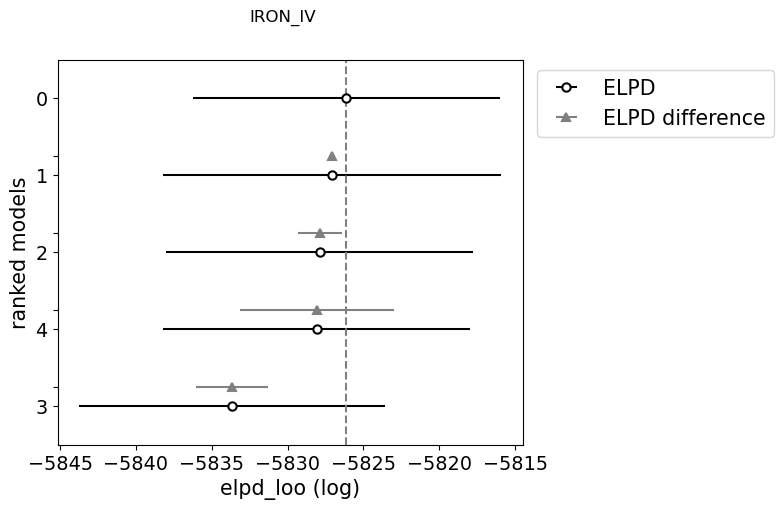

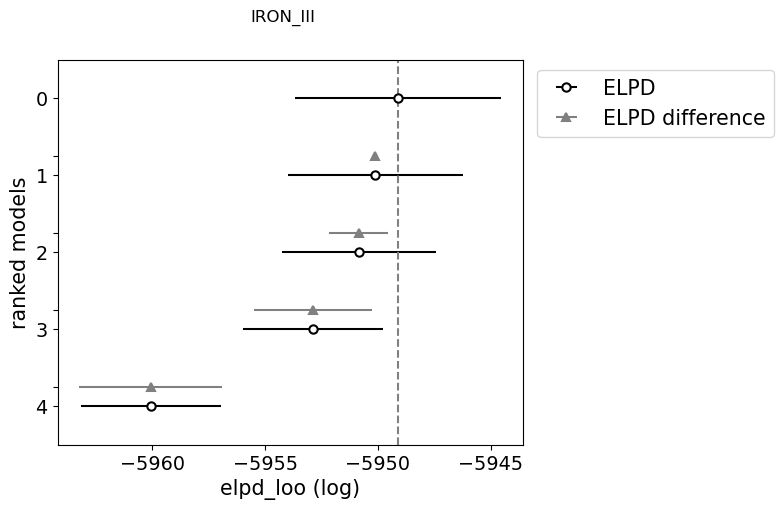

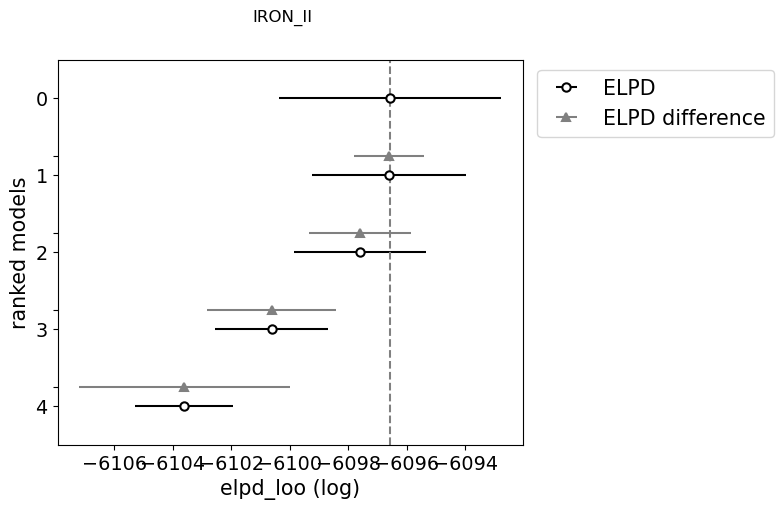

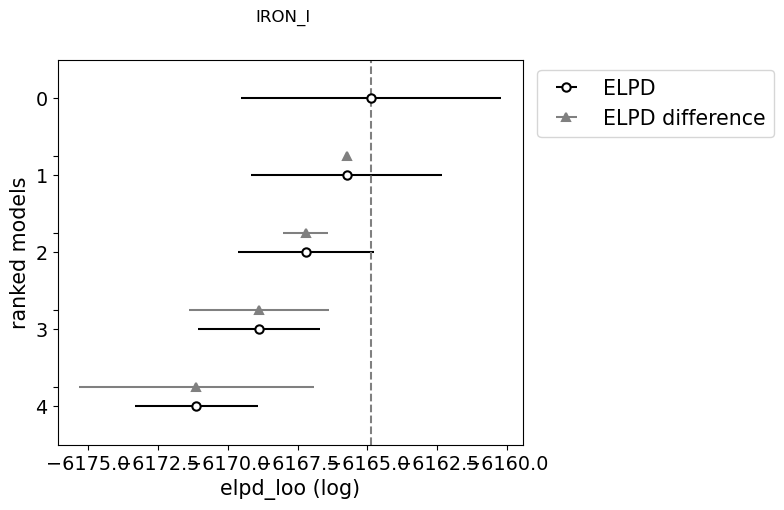

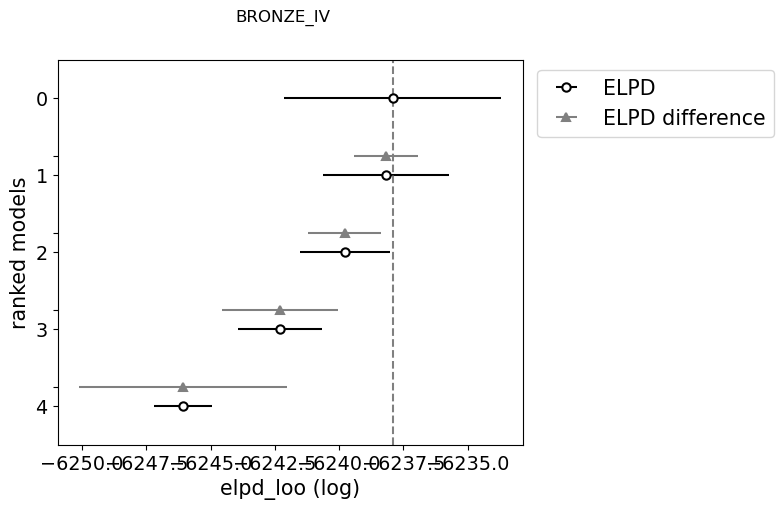

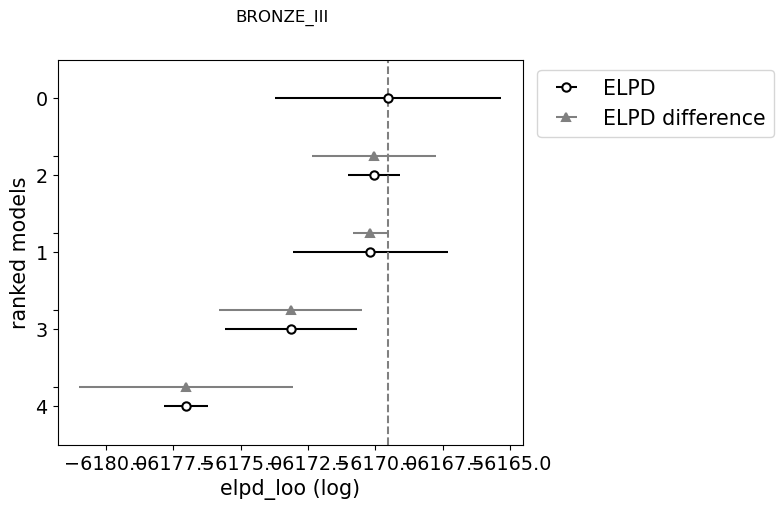

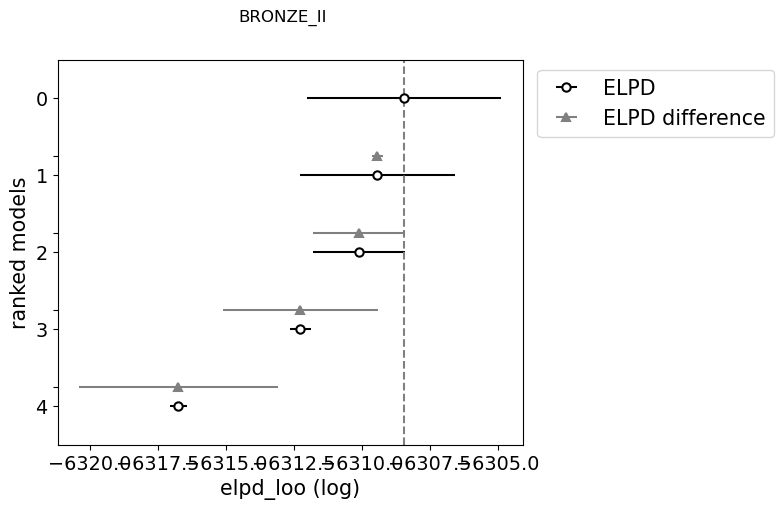

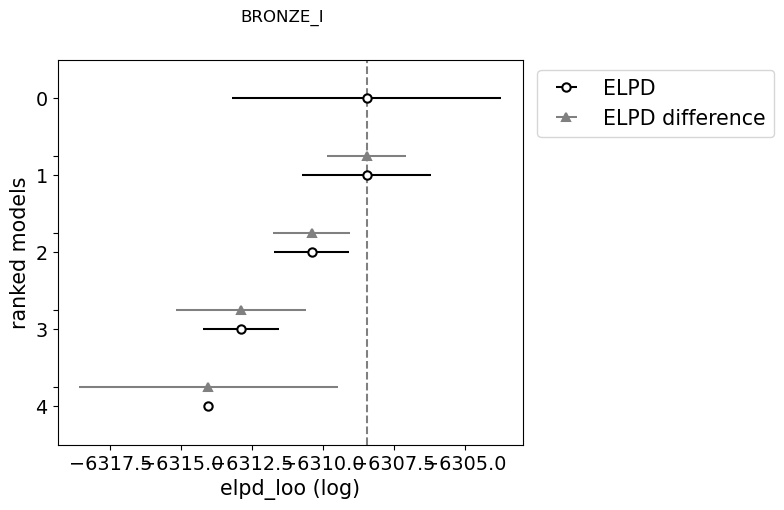

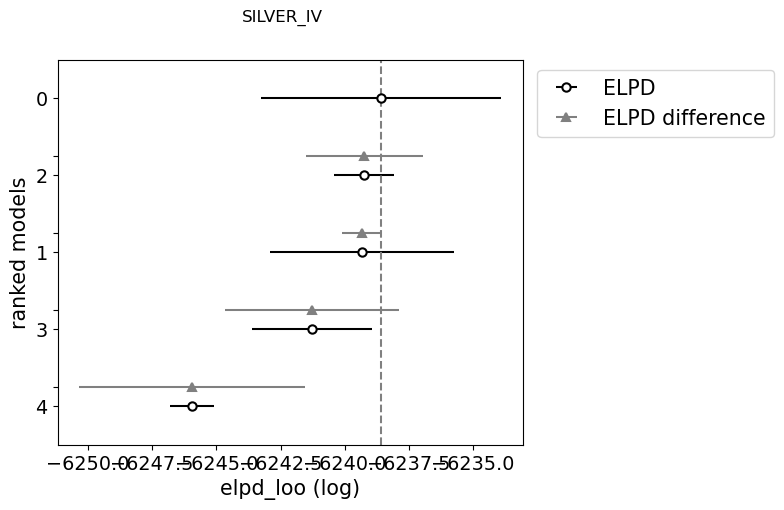

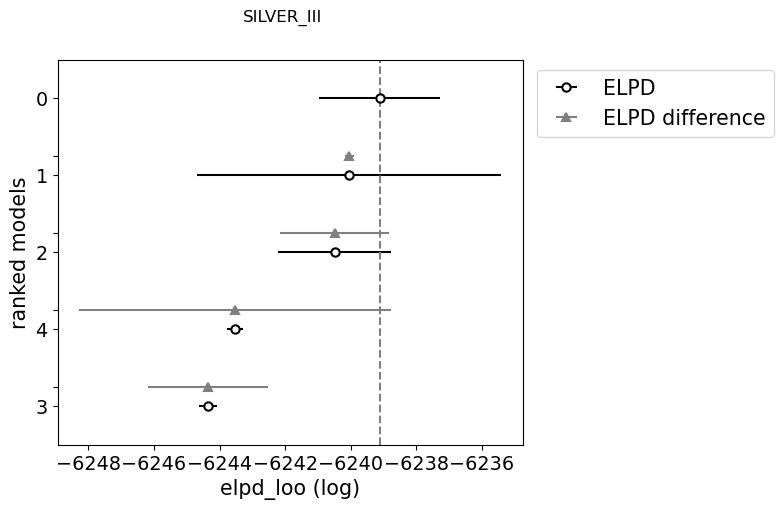

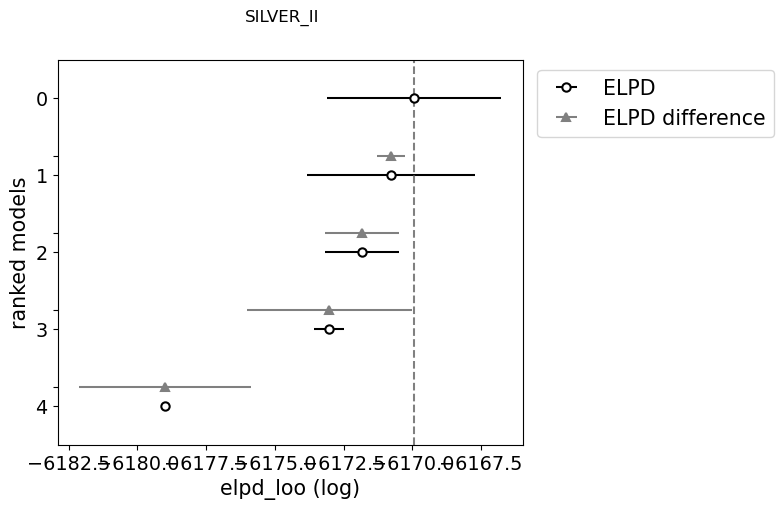

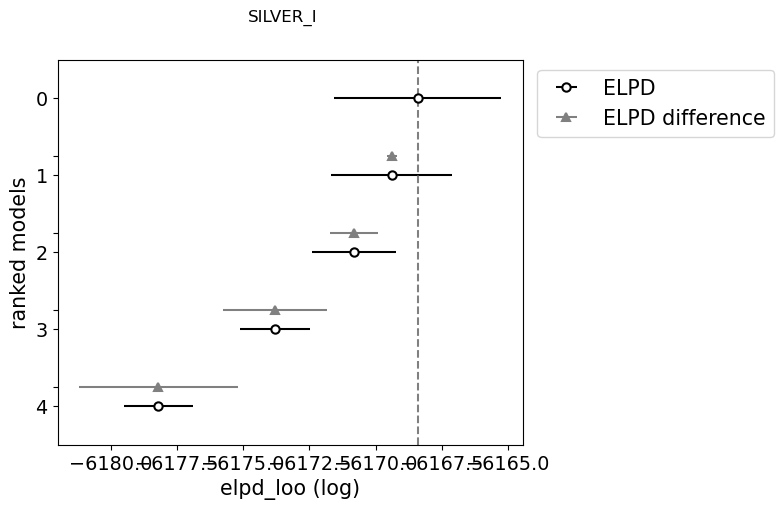

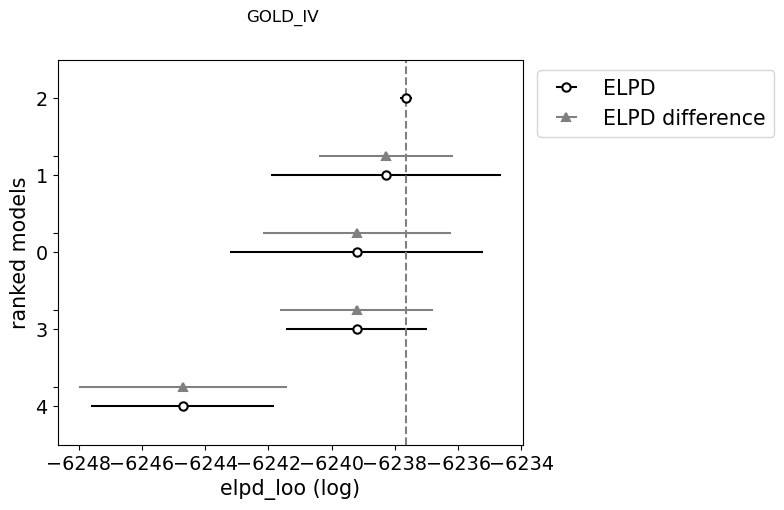

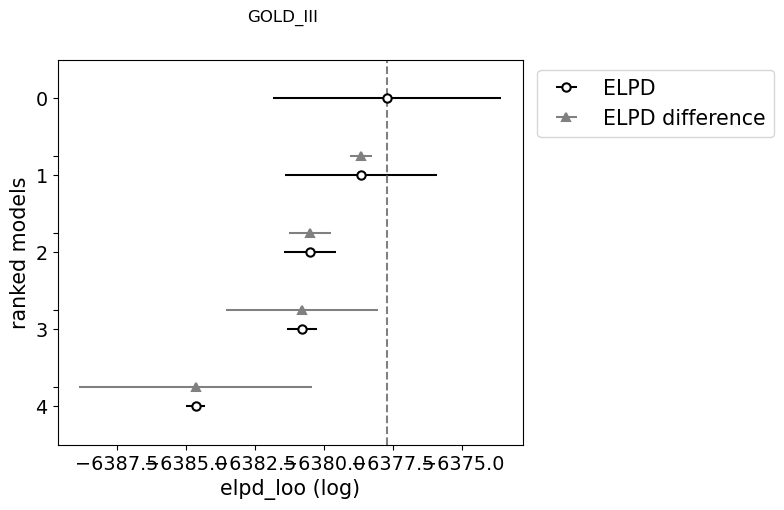

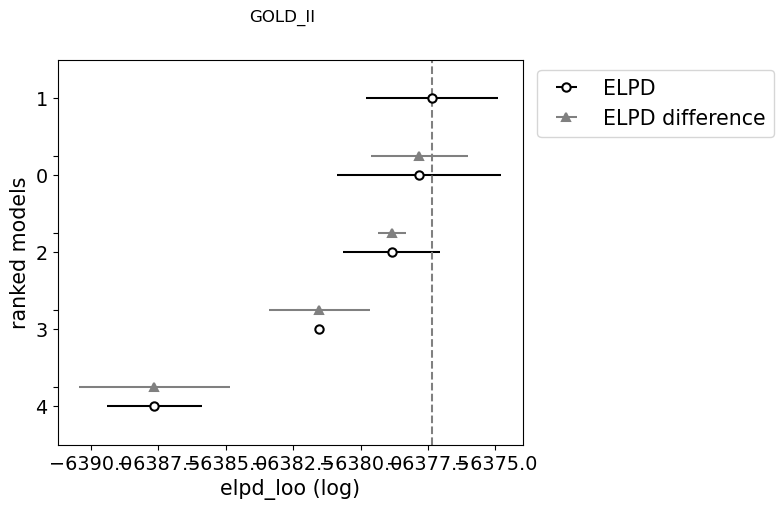

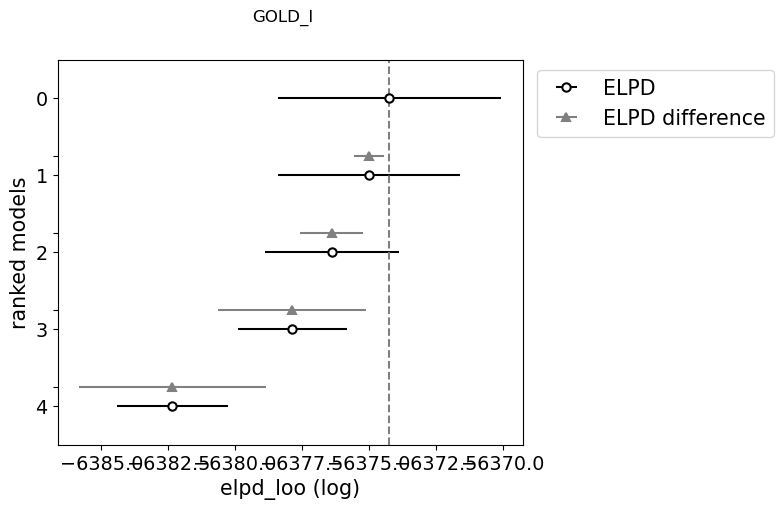

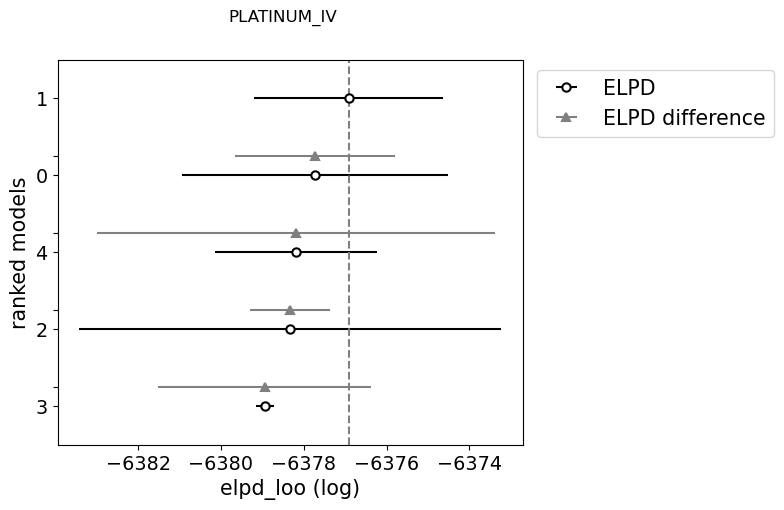

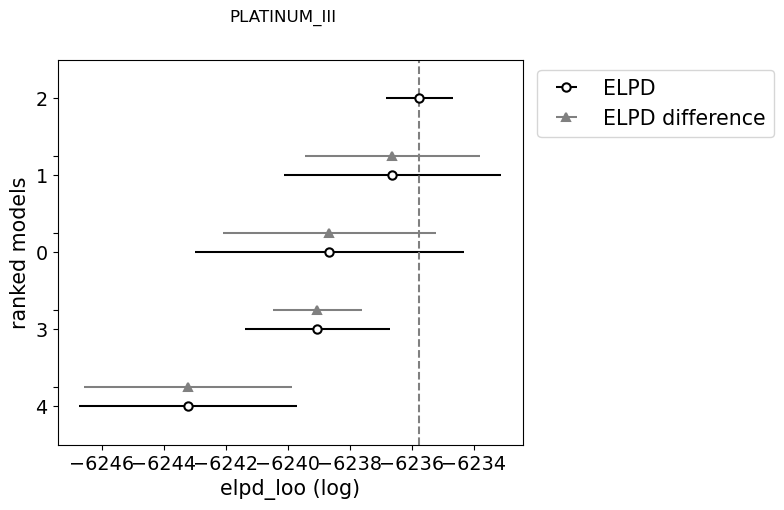

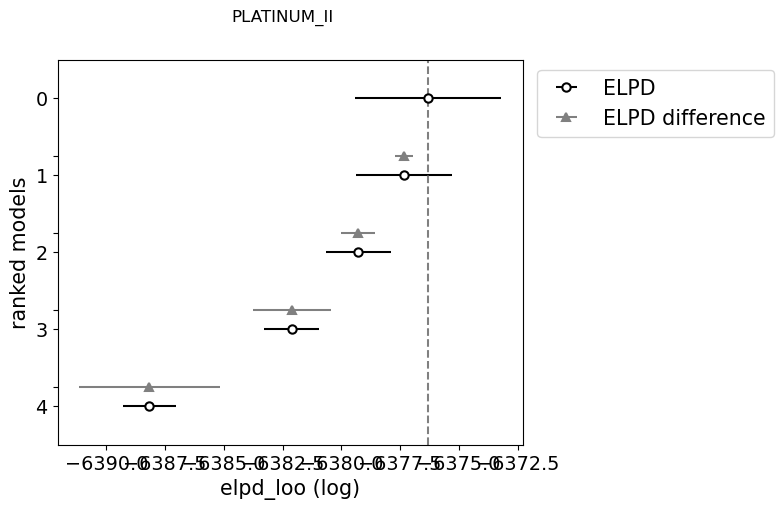

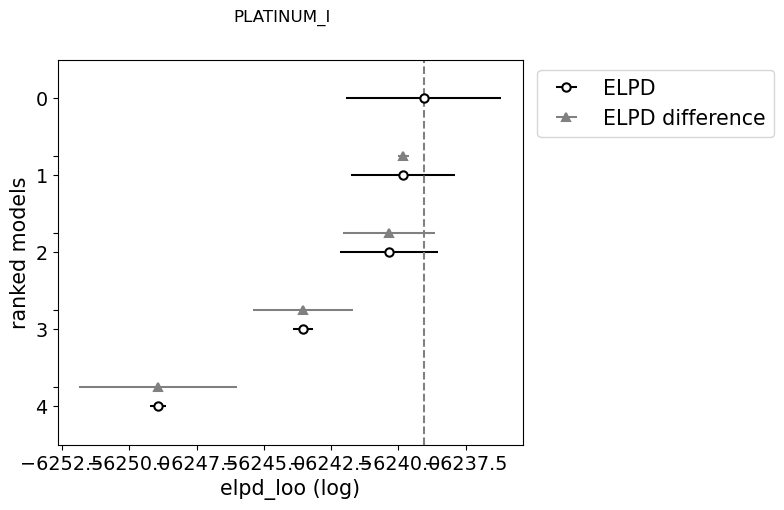

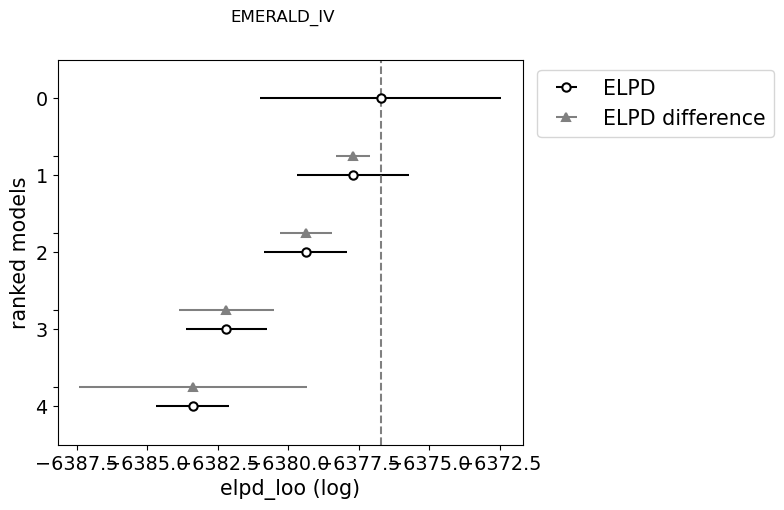

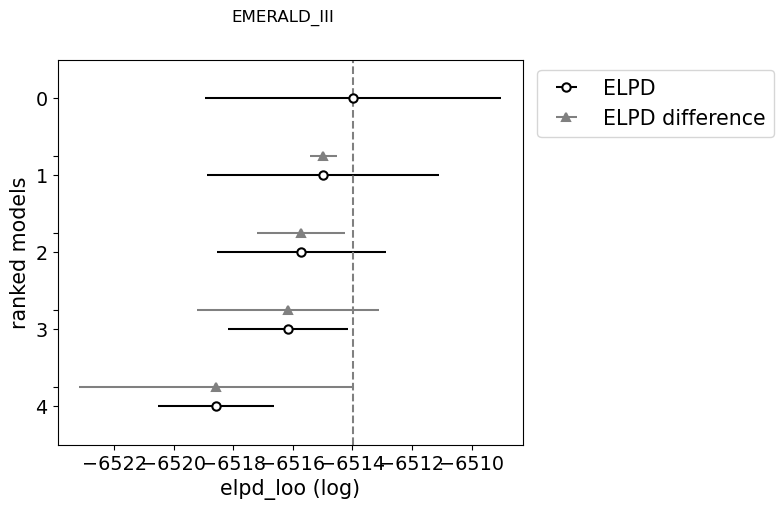

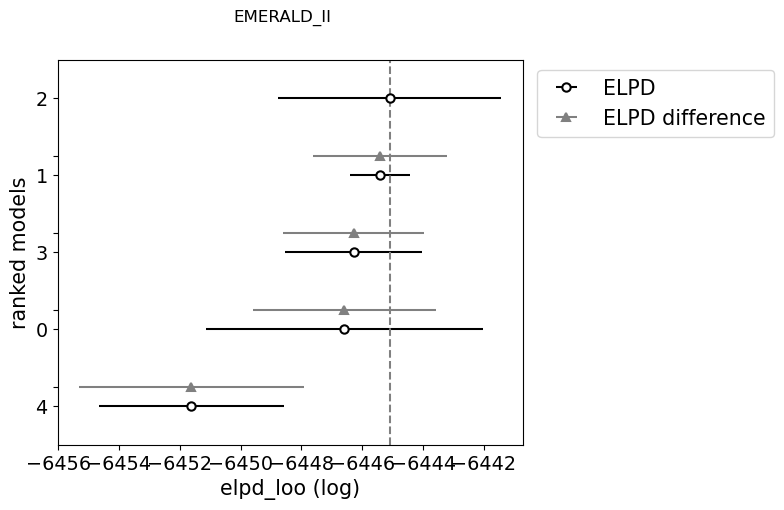

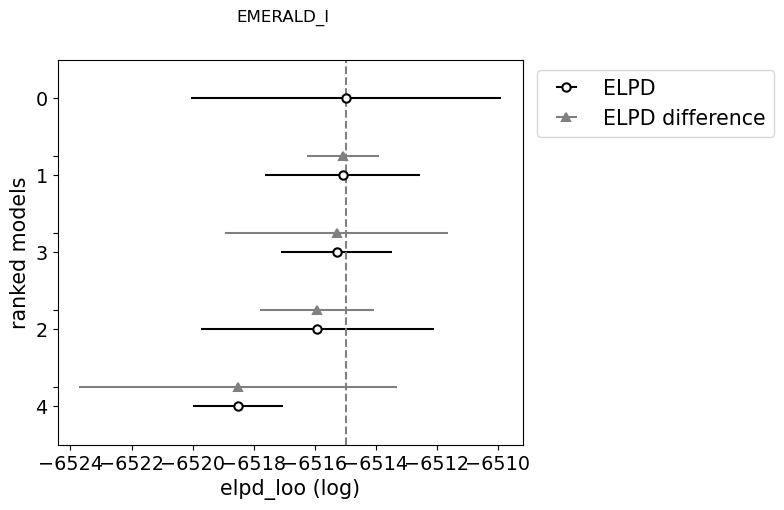

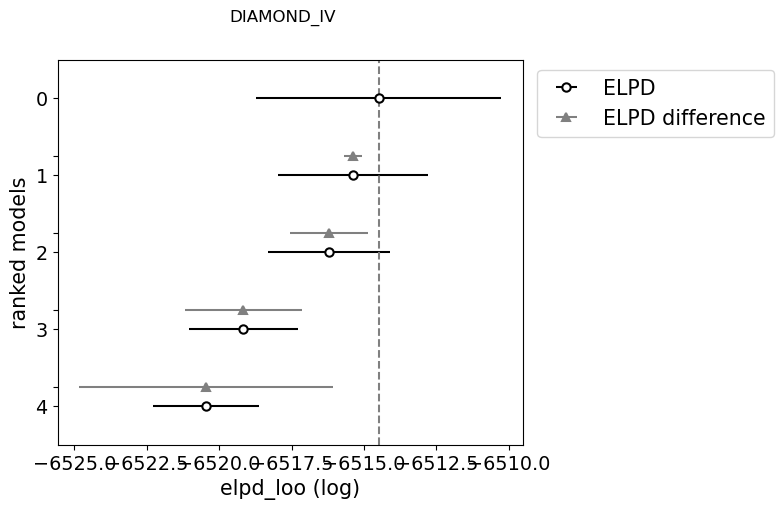

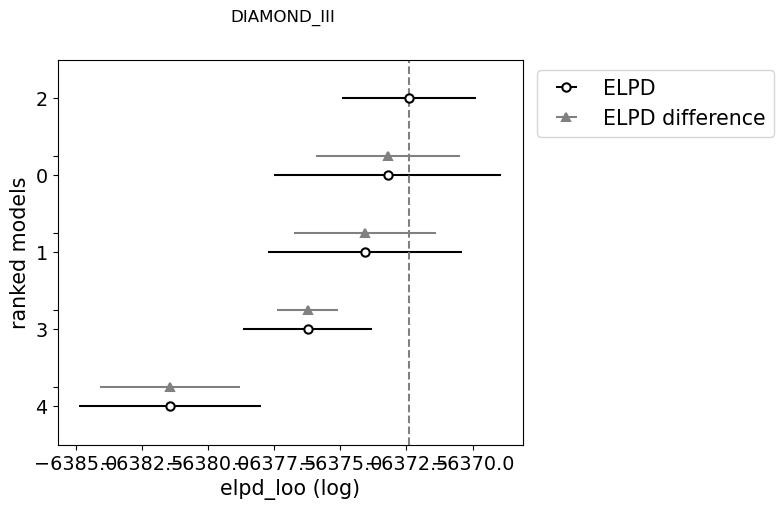

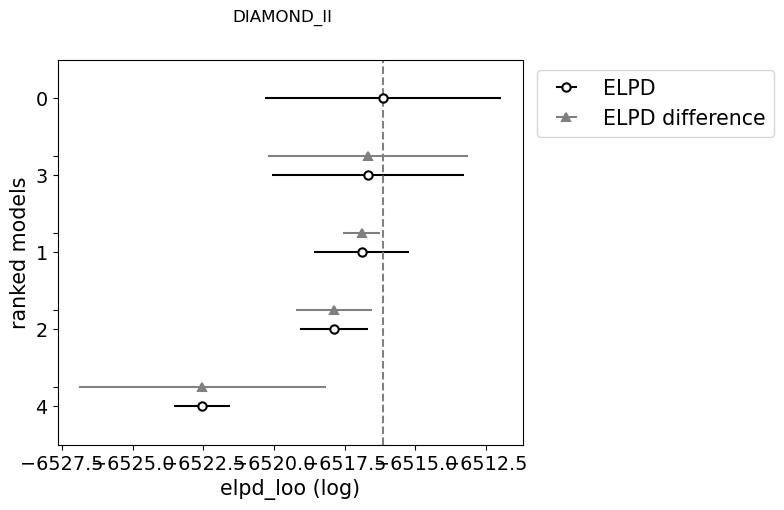

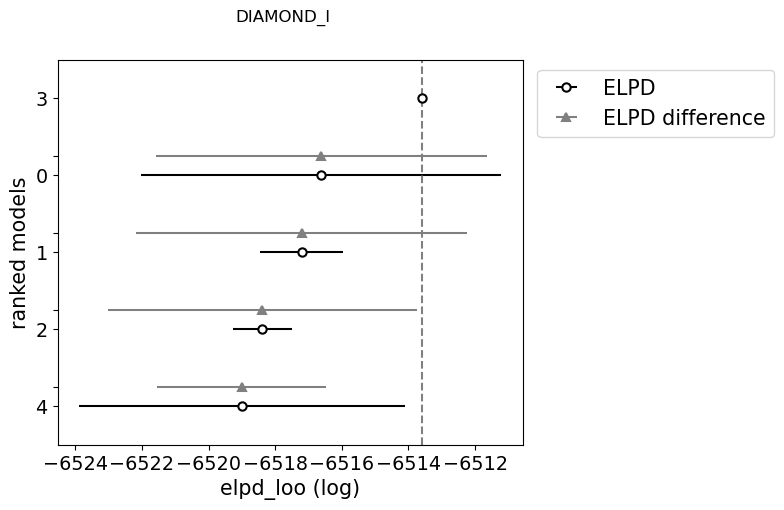

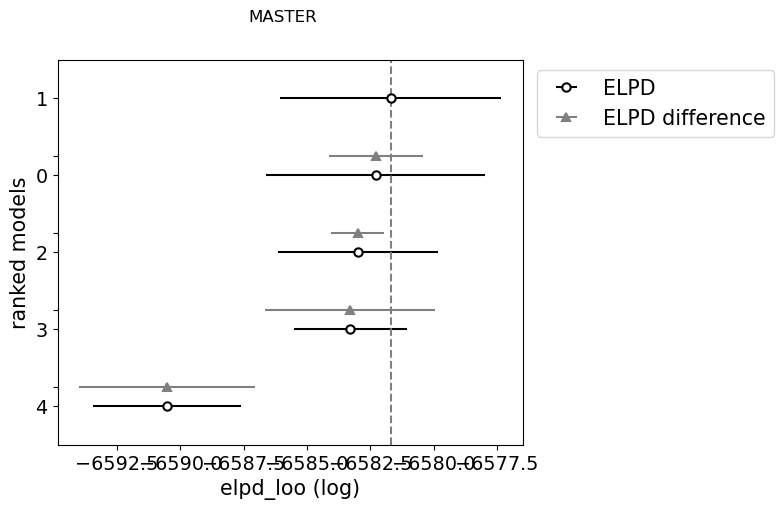

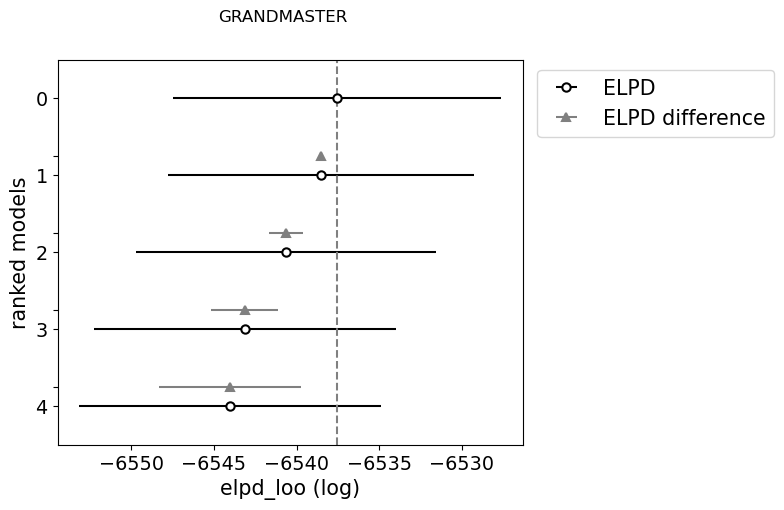

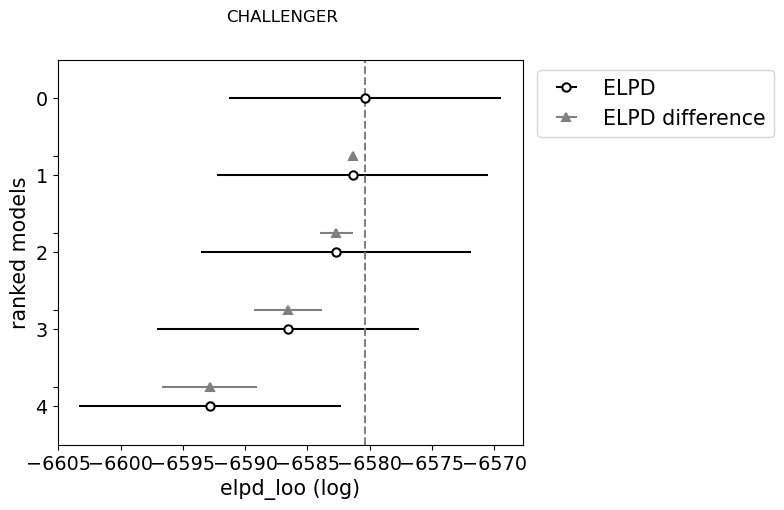

In [54]:
for key, value in results_per_tier.items():

    az.plot_compare(
        az.compare(value, method="BB-pseudo-BMA"), 
        title=False
    )
    plt.suptitle(key)
    plt.show()